In [1]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
def seed_it(seed):
    random.seed(seed) #可以注释掉
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) #这个懂吧
    torch.backends.cudnn.deterministic = True #确定性固定
    torch.backends.cudnn.benchmark = True #False会确定性地选择算法，会降低性能
    torch.backends.cudnn.enabled = True  #增加运行效率，默认就是True
    torch.manual_seed(seed)
seed_it(1314)

In [3]:
class Generator(nn.Module):
    def __init__(self, nc=10, nz=100, n_out=1, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz+nc, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, n_out, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [4]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [5]:
dataset = dset.MNIST(root='./data', download=True,
                     transform=transforms.Compose([
                         #transforms.Resize(imageSize),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5,)),
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nc = 1
nz = 100
ngf = 8
ndf = 8

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = Generator(ngf=ngf).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(8, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


In [8]:
netD = Discriminator(ndf=ndf).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(2, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:
teacher_G = Generator(ngf=64).to(device)
teacher_G.load_state_dict(torch.load('./checkpoint_cgan/netG_epoch_24.pth'))

<All keys matched successfully>

In [10]:
fixed_input = torch.load('./fixed_input.pth')

In [11]:
fixed_input.shape

torch.Size([80, 110, 1, 1])

In [12]:
outf = './checkpoint_cgan_distill_8'
os.mkdir(outf)

GAN_criterion = nn.BCELoss()
L1_criterion = nn.L1Loss()

real_label = 1.
fake_label = 0.

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))


img_list = []
G_losses = []
D_losses = []
G_gan_losses = []



for epoch in range(25):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        
        images, real_conditions = data
        
        real_cpu = images.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        real_d_conditions = torch.unsqueeze(real_conditions,1)
        real_d_conditions = torch.unsqueeze(real_d_conditions,2)
        real_d_conditions = torch.unsqueeze(real_d_conditions,3)
        real_d_conditions = real_d_conditions.expand(-1,-1,28,28)
        real_d_conditions = real_d_conditions.to(device)
        
        real_d_input = torch.cat([real_cpu, real_d_conditions], 1)

        output = netD(real_d_input).view(-1)
        errD_real = GAN_criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        
        fake_conditions = torch.randint(0, 10, (batch_size,)).to(device)
        
        fake_g_conditions = torch.unsqueeze(fake_conditions,1).expand(batch_size,10)
        fake_g_conditions = torch.unsqueeze(fake_g_conditions,2)
        fake_g_conditions = torch.unsqueeze(fake_g_conditions,3)
        fake_g_conditions = fake_g_conditions.to(device)
        fake_g_input = torch.cat([noise, fake_g_conditions], 1)
        
        fake = netG(fake_g_input)
        label.fill_(fake_label)
        
        fake_d_conditions = torch.unsqueeze(fake_conditions,1)
        fake_d_conditions = torch.unsqueeze(fake_d_conditions,2)
        fake_d_conditions = torch.unsqueeze(fake_d_conditions,3)
        fake_d_conditions = fake_d_conditions.expand(-1,-1,28,28)
        fake_d_conditions = fake_d_conditions.to(device)
        
        fake_d_input = torch.cat([fake, fake_d_conditions], 1)
        
        output = netD(fake_d_input.detach()).view(-1)
        errD_fake = GAN_criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        output = netD(fake_d_input).view(-1)
        
        fake_teacher = teacher_G(fake_g_input)
        
        
        errG_gan = GAN_criterion(output, label)
        errG_reconst = L1_criterion(fake_teacher, fake)
        errG = errG_gan + errG_reconst
        
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\nLoss_G_gan: %.4f\tLoss_G_reconst: %.4f\n D(x): %.4f\tD(G(z)): %.4f / %.4f\n'
                  % (epoch, 25, i, len(dataloader),
                     errD.item(), errG.item(), 
                     errG_gan.item(), errG_reconst.item(), 
                     D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        G_gan_losses.append(errG_gan.item())

    with torch.no_grad():
        fake = netG(fixed_input).detach().cpu()
    vutils.save_image(fake.detach(),
                      '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                      normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/469]	Loss_D: 1.3851	Loss_G: 1.7320
Loss_G_gan: 0.7651	Loss_G_reconst: 0.9669
 D(x): 0.4626	D(G(z)): 0.4584 / 0.4655

[0/25][100/469]	Loss_D: 0.0614	Loss_G: 4.5784
Loss_G_gan: 3.6172	Loss_G_reconst: 0.9612
 D(x): 0.9706	D(G(z)): 0.0309 / 0.0295

[0/25][200/469]	Loss_D: 0.0208	Loss_G: 5.5641
Loss_G_gan: 4.6008	Loss_G_reconst: 0.9633
 D(x): 0.9906	D(G(z)): 0.0113 / 0.0108

[0/25][300/469]	Loss_D: 0.0107	Loss_G: 6.2857
Loss_G_gan: 5.3404	Loss_G_reconst: 0.9453
 D(x): 0.9956	D(G(z)): 0.0063 / 0.0057

[0/25][400/469]	Loss_D: 0.0064	Loss_G: 6.9505
Loss_G_gan: 6.0286	Loss_G_reconst: 0.9219
 D(x): 0.9962	D(G(z)): 0.0025 / 0.0026

[1/25][0/469]	Loss_D: 0.0052	Loss_G: 7.0285
Loss_G_gan: 6.1250	Loss_G_reconst: 0.9035
 D(x): 0.9972	D(G(z)): 0.0024 / 0.0024

[1/25][100/469]	Loss_D: 0.0035	Loss_G: 7.2593
Loss_G_gan: 6.3853	Loss_G_reconst: 0.8739
 D(x): 0.9983	D(G(z)): 0.0018 / 0.0018

[1/25][200/469]	Loss_D: 0.0048	Loss_G: 7.3266
Loss_G_gan: 6.4855	Loss_G_reconst: 0.8410
 D(x): 0.9963	D(G(z)

[13/25][0/469]	Loss_D: 1.4245	Loss_G: 0.8659
Loss_G_gan: 0.6247	Loss_G_reconst: 0.2412
 D(x): 0.6136	D(G(z)): 0.5952 / 0.5383

[13/25][100/469]	Loss_D: 1.1366	Loss_G: 1.2899
Loss_G_gan: 1.0433	Loss_G_reconst: 0.2466
 D(x): 0.5125	D(G(z)): 0.3678 / 0.3554

[13/25][200/469]	Loss_D: 1.3465	Loss_G: 0.9495
Loss_G_gan: 0.7246	Loss_G_reconst: 0.2249
 D(x): 0.4879	D(G(z)): 0.4615 / 0.4863

[13/25][300/469]	Loss_D: 1.3314	Loss_G: 1.0912
Loss_G_gan: 0.8613	Loss_G_reconst: 0.2299
 D(x): 0.4475	D(G(z)): 0.4047 / 0.4250

[13/25][400/469]	Loss_D: 1.3191	Loss_G: 1.0909
Loss_G_gan: 0.8654	Loss_G_reconst: 0.2256
 D(x): 0.4496	D(G(z)): 0.3977 / 0.4229

[14/25][0/469]	Loss_D: 1.2305	Loss_G: 1.0291
Loss_G_gan: 0.7901	Loss_G_reconst: 0.2390
 D(x): 0.4925	D(G(z)): 0.4001 / 0.4558

[14/25][100/469]	Loss_D: 1.2119	Loss_G: 1.1144
Loss_G_gan: 0.8968	Loss_G_reconst: 0.2176
 D(x): 0.5123	D(G(z)): 0.4139 / 0.4096

[14/25][200/469]	Loss_D: 1.2640	Loss_G: 0.9463
Loss_G_gan: 0.7401	Loss_G_reconst: 0.2062
 D(x): 0.556

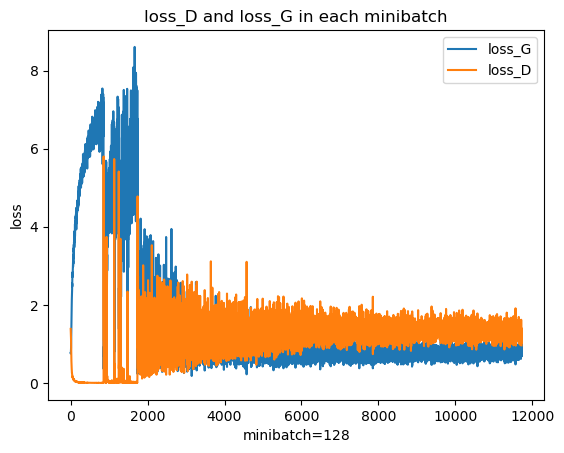

In [13]:
x_lim = range(len(G_losses))
plt.plot(x_lim, G_gan_losses, label='loss_G')
plt.plot(x_lim, D_losses, label='loss_D')
plt.xlabel('minibatch=128')
plt.ylabel('loss')
plt.title('loss_D and loss_G in each minibatch')
plt.legend()
plt.show()

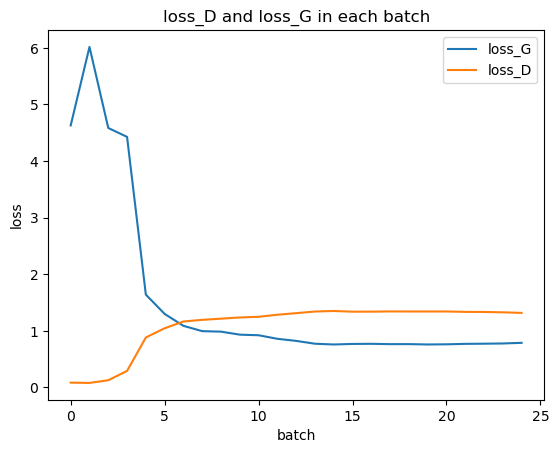

In [14]:
G_batch_loss = []
D_batch_loss = []
g_loss = 0
d_loss = 0
batch = 469
for i in range(25):
    for j in range(469):
        g_loss = g_loss + G_gan_losses[i*batch+j]
        d_loss = d_loss + D_losses[i*batch+j]
    g_loss = g_loss/469
    d_loss = d_loss/469
    
    G_batch_loss.append(g_loss)
    D_batch_loss.append(d_loss)
    
    g_loss = 0
    d_loss = 0
    
x_lim = range(25)
plt.plot(x_lim, G_batch_loss,label='loss_G')
plt.plot(x_lim, D_batch_loss,label='loss_D')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss_D and loss_G in each batch')
plt.legend()
plt.show()